In [1]:
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import arviz as az
import pandas as pd
import plotly.express as px

## Factor data

In [2]:
mean_1 = 0
mean_2 = 5
std = 1
N = 100
y = np.r_[np.random.randn(N)*std + mean_1, np.random.randn(N)*std + mean_2]
f = np.array(np.r_[np.zeros(N), np.ones(N)]).astype("int")
df = pd.DataFrame({"factor": f, "value": y})
df["factor"] = df["factor"].astype("category")
df

,factor,value
0,0,-1.230743
1,0,0.636513
2,0,-0.284654
3,0,0.516209
4,0,-0.459948
...,...,...
195,1,5.166010
196,1,4.047624
197,1,5.832670
198,1,5.531668


value          
            mean       std
factor                    
0       0.026446  0.944169
1       5.005803  0.989283

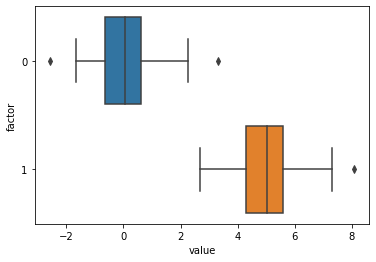

In [3]:
#px.histogram(df, x="value", color="factor")
sns.boxplot(data=df, x="value", y="factor")
df.groupby("factor").agg(["mean", "std"])

## Hierarchical model, common std

\begin{align*}
y_{ij} &\sim \mathcal{N}(\mu_j, \sigma_j) \\
\mu_{j} &\sim \mathcal{N}(0, 1) \\
\sigma_{j} &\sim |\mathcal{N}|(0, \sigma_j) \\
\end{align*}



* Implement the hierarchical model with common std in pymc3

In [4]:
df["factor_id"] = df["factor"].cat.codes
factors = list(df["factor"].cat.categories)
n_factors = len(factors) # number of machines (6)

In [14]:
with pm.Model() as model_hierarchical:
    
    # hyper_priors
    hyper_mu_mu = pm.Normal('hyper_mu_mu', mu=92, sd=100)
    hyper_mu_std = pm.HalfNormal('hyper_mu_std', sd=100)

    # priors    
    group_mu = pm.Normal('group_mu', mu=hyper_mu_mu, sd=hyper_mu_std, shape=n_factors)
    std = pm.HalfNormal('std', sd=100)
    y = pm.Normal('y', mu=group_mu[df["factor_id"]], sd=std, observed=df["value"])
    
    # prediction
    pred_mu = pm.Normal('pred_mu', mu=hyper_mu_mu, sd=hyper_mu_std)
    pred_y = pm.Normal('pred_y', mu=pred_mu, sd=std)
    
    
    trace_hierarchical = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pred_y, pred_mu, std, group_mu, hyper_mu_std, hyper_mu_mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
The acceptance probability does not match the target. It is 0.8908318853756659, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9526569171452879, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


In [12]:
with model_hierarchical:
    display(az.summary(trace_hierarchical))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
hyper_mu_mu,7.948,23.751,-31.300,64.698,0.884,0.747,1162.0,712.0,1.01
group_mu[0],0.029,0.100,-0.160,0.214,0.002,0.002,1712.0,2017.0,1.00
group_mu[1],5.007,0.095,4.824,5.181,0.002,0.002,1498.0,2218.0,1.00
pred_mu,6.374,48.213,-82.545,111.842,1.921,1.521,759.0,632.0,1.01
pred_y,6.357,48.251,-82.740,112.630,1.924,1.522,755.0,547.0,1.01
hyper_mu_std,29.567,32.912,1.190,92.424,1.795,1.270,337.0,735.0,1.01
std,0.977,0.048,0.884,1.063,0.002,0.001,493.0,1944.0,1.02


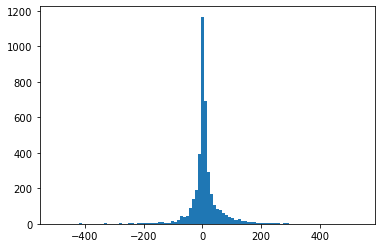

In [18]:
plt.hist(np.array(trace_hierarchical.posterior.pred_y).ravel(), bins=100);